## Yandex boot camp - Milestone 2

The data analysed consists of log files from a startup app. The sales funnel will be investigated to find out where users get stuck and what percentage of them reaches the purchase stage. In order to test the effect of a visual change, users have been split up into two control and one experimental group. Tests will be conducted to find out whether the latter is performing differently than the former two and if yes, in what way.

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from scipy.stats import norm
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import chisquare

%matplotlib inline

# import file
log = pd.read_csv('logs_exp_us.csv', sep='\t')

### 1. Prepare and study data for analysis

In [2]:
log.head(3)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248


In [3]:
log.set_axis(['event','user_id','unix_time','exp_id'],axis=1,inplace=True)

In [4]:
log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   event      244126 non-null  object
 1   user_id    244126 non-null  int64 
 2   unix_time  244126 non-null  int64 
 3   exp_id     244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [5]:
log.isnull().sum()

event        0
user_id      0
unix_time    0
exp_id       0
dtype: int64

In [6]:
log.duplicated().sum()

413

In [7]:
log = log.drop_duplicates().reset_index(drop=True)

Columns renamed. No missing values detected. Around 400 duplicates found and dropped (less than 0.2% of data set)

In [8]:
log['timestamp'] = log.unix_time.apply(lambda x: datetime.datetime.fromtimestamp(x))

In [9]:
log['date'] = pd.to_datetime(log['timestamp'].dt.date,format='%Y-%m-%d')

In [10]:
log.drop('unix_time',axis=1,inplace=True)

Unix time converted into human readable form. Two columns created, one with the exact timestamp, one with the date. 

In [11]:
log.exp_id.value_counts()

248    85582
246    80181
247    77950
Name: exp_id, dtype: int64

In [12]:
log.event.value_counts()

MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: event, dtype: int64

In [13]:
log.user_id.nunique()

7551

In [14]:
round(log.groupby('user_id').agg({'event':'count'}).mean(),2)

event    32.28
dtype: float64

In [15]:
round(log.groupby('user_id').agg({'event':'nunique'}).mean(),2)

event    2.67
dtype: float64

Data is split into three groups of comparable size. Five different events are recorded. Number of unique users lies at 7551 with each of them performing 32 (2.7 unique) events.

In [16]:
log.date.min()

Timestamp('2019-07-25 00:00:00')

In [17]:
log.date.max()

Timestamp('2019-08-07 00:00:00')

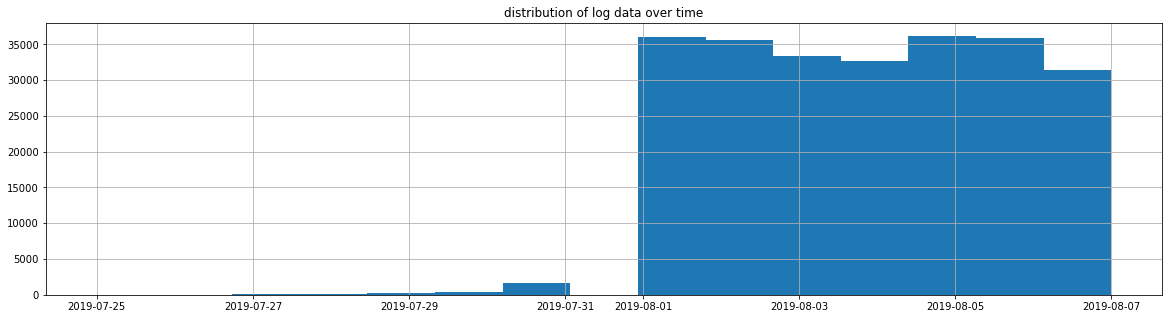

In [18]:
log.date.hist(bins=15,figsize=(20,5))
plt.title('distribution of log data over time');

Data stretches from the 25th of July until the 7th of August. As the histogram shows, a neglectable part of the data points fall into the end of july period and will thus be excluded in the next step.

In [19]:
log.shape[0]

243713

In [20]:
log[log.date<=('2019-07-31')].count()[0]

2413

In [21]:
log.drop(log[log.date<=('2019-07-31')].index,inplace=True)

In [22]:
log.user_id.nunique()

7538

Around 1% of data was dropped by exluding the july week and 13 out of initially 7551 unique users. The percentage is small enough to not affect the distribution among the events or experimental groups in any meaningful way.

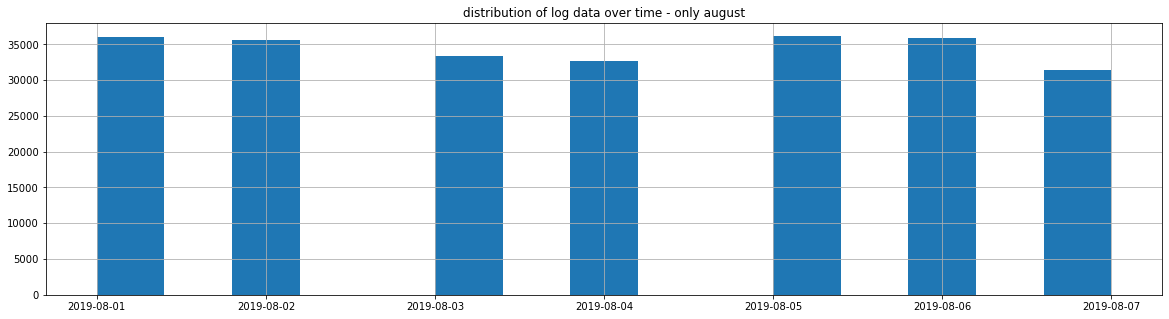

In [23]:
log.date.hist(bins=15,figsize=(20,5))
plt.title('distribution of log data over time - only august');

The distribution of data in the remaining august period looks relatively uniform, not revealing any preferences of the users for certain days of the week (e.g. saturday and sunday).

In [24]:
log.groupby('exp_id').agg({'user_id':['count','nunique']})

user_id        
         count nunique
exp_id                
246      79440    2484
247      77136    2517
248      84724    2537

**Intermediary Conclusion 1:** The data set is ready for analysis. We have around 80.000 events from 2.500 unique users per experimental group. Duplicates and older data have been dropped and the timestamp converted into a human readable format.

### 2. User shares in the event funnel

In [25]:
log.event.value_counts()

MainScreenAppear           117617
OffersScreenAppear          46420
CartScreenAppear            42322
PaymentScreenSuccessful     33935
Tutorial                     1006
Name: event, dtype: int64

In [26]:
event_users = log.groupby('event').agg({'user_id':'nunique'}).sort_values('user_id',ascending=False)
event_users.columns=['user_count']
event_users['user_share']=round(event_users.user_count/log.user_id.nunique(),2)
event_users

,user_count,user_share
event,,
MainScreenAppear,7423,0.98
OffersScreenAppear,4595,0.61
CartScreenAppear,3735,0.50
PaymentScreenSuccessful,3539,0.47
Tutorial,841,0.11


In the order of frequency, the sales funnel of the app is designed by the screens Main -> Offers -> Cart -> Payment. There is also a tutorial which is not related to the sales funnel and will be ignored in further analysis. The (unique) user shares of the different events are 98% (main), 61% (offers), 50% (cart) and a whooping 48% (payment) that reach the checkout.

In [27]:
log[log.event!='Tutorial'].pivot_table(index='exp_id',columns='event',values='user_id',aggfunc='nunique')

event,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful
exp_id,,,,
246,1266,2450,1542,1200
247,1239,2479,1522,1158
248,1230,2494,1531,1181


In [28]:
main_six = log[(log.event=='MainScreenAppear') & (log.exp_id==246)].nunique()[1]
main_seven = log[(log.event=='MainScreenAppear') & (log.exp_id==247)].nunique()[1]
main_eight = log[(log.event=='MainScreenAppear') & (log.exp_id==248)].nunique()[1]
offer_six = log[(log.event=='OffersScreenAppear') & (log.exp_id==246)].nunique()[1]
offer_seven = log[(log.event=='OffersScreenAppear') & (log.exp_id==247)].nunique()[1]
offer_eight = log[(log.event=='OffersScreenAppear') & (log.exp_id==248)].nunique()[1]
cart_six = log[(log.event=='CartScreenAppear') & (log.exp_id==246)].nunique()[1]
cart_seven = log[(log.event=='CartScreenAppear') & (log.exp_id==247)].nunique()[1]
cart_eight = log[(log.event=='CartScreenAppear') & (log.exp_id==248)].nunique()[1]
payment_six = log[(log.event=='PaymentScreenSuccessful') & (log.exp_id==246)].nunique()[1]
payment_seven = log[(log.event=='PaymentScreenSuccessful') & (log.exp_id==247)].nunique()[1]
payment_eight = log[(log.event=='PaymentScreenSuccessful') & (log.exp_id==248)].nunique()[1]

In [29]:
d_one = {'offer_main':[offer_six/main_six,offer_seven/main_seven,offer_eight/main_eight],
    'cart_offer':[cart_six/offer_six,cart_seven/offer_seven,cart_eight/offer_eight],
    'payment_cart':[payment_six/cart_six,payment_seven/cart_seven,payment_eight/cart_eight]}

In [30]:
# create dataframe with ratios of users from the three groups that pass from one stage to the next
funnel_one = pd.DataFrame(data=d_one, index=['exp_six','exp_seven','exp_eight'])

In [31]:
funnel_one

,offer_main,cart_offer,payment_cart
exp_six,0.629388,0.821012,0.947867
exp_seven,0.613957,0.814060,0.934625
exp_eight,0.613873,0.803396,0.960163


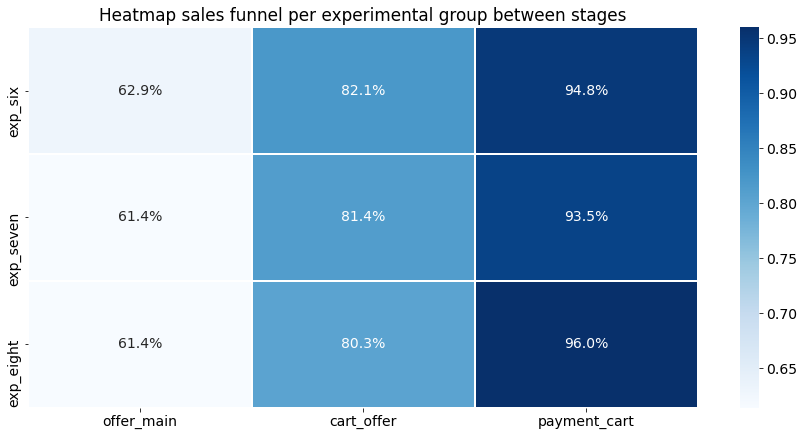

In [32]:
plt.figure(figsize=(15,7))
plt.rcParams['font.size']='14'
plt.title('Heatmap sales funnel per experimental group between stages')
sns.heatmap(funnel_one,annot=True,fmt='.1%',linewidths=1,linecolor='white',cmap='Blues');

The heatmap shows ratios of users that pass on from one stage to the next, broken down per experimental group. Most users are lost between the main and the offer screen. That still means that very decent 3 out of 5 users reach this stage. 4 out of 5 users go from offer to cart screen and only 1 out of 20 still pulls pack between car and payment screen. Those are incredibly good numbers, while the biggest potential seems to lie between main and offer screen.

Differences between the experimental groups are not huge, even though the group with altered fonts (248 or exp_eight) has slightly higher values between cart and payment screen and lower ones between offer and cart screen than the control groups.

In [33]:
d_two = {'offer_main':[offer_six/main_six,offer_seven/main_seven,offer_eight/main_eight],
    'cart_main':[cart_six/main_six,cart_seven/main_seven,cart_eight/main_eight],
    'payment_main':[payment_six/main_six,payment_seven/main_seven,payment_eight/main_eight]}

In [34]:
# create dataframe with ratios of users from the three groups that pass from the first stage to the following ones
funnel_two = pd.DataFrame(data=d_two, index=['exp_six','exp_seven','exp_eight'])

In [35]:
funnel_two

,offer_main,cart_main,payment_main
exp_six,0.629388,0.516735,0.489796
exp_seven,0.613957,0.499798,0.467124
exp_eight,0.613873,0.493184,0.473536


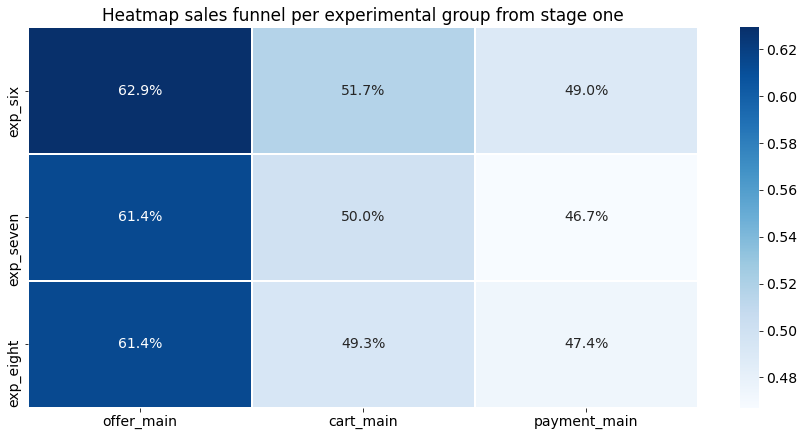

In [36]:
plt.figure(figsize=(15,7))
plt.rcParams['font.size']='14'
plt.title('Heatmap sales funnel per experimental group from stage one')
sns.heatmap(funnel_two,annot=True,fmt='.1%',linewidths=1,linecolor='white',cmap='Blues');

**Intermediary Conclusion 2:** Almost half of the users in all groups make it through the whole sales channel to reach the payment screen. It is very noteable, that the ratio of the experimental group (248 or exp_eight) of 47.4% lies between the values of the two control groups (49.0% vs. 46.7%). That basically exludes the option already that the altered font has a notable impact on customer behaviour. We'll still perform various hypothesis tests to confirm this assumption in the next part and check for statistically significant differences between the previous stages.

### 3. Experiments on sample groups

In [37]:
# Users that reached payment stage
users_with_payment = log[log.event=='PaymentScreenSuccessful']['user_id']

In [38]:
exp_users = log.groupby('user_id').agg({'exp_id':'first'}).reset_index()

In [39]:
# All users with boolean value if payment stage was reached or not
exp_users.loc[exp_users.user_id.isin(users_with_payment), 'till_payment'] = True

In [40]:
exp_users.till_payment.fillna(False, inplace=True)

In [41]:
exp_users.head(3)

,user_id,exp_id,till_payment
0,6888746892508752,246,False
1,6909561520679493,247,True
2,6922444491712477,246,True


In [42]:
payment_six = exp_users[exp_users.exp_id==246]['till_payment']
payment_seven = exp_users[exp_users.exp_id==247]['till_payment']
payment_eight = exp_users[exp_users.exp_id==248]['till_payment']

In [43]:
def draw_norm(payment_group):
    n = payment_group.shape[0]
    p = payment_group.value_counts()[1] / n
    mu = n * p
    var = mu * (1 - p)
    sigma = var ** 0.5
    x = range(0,n+1)
    print(mu)
    print(sigma)
    plt.xlim(mu-sigma*5,mu+sigma*5)
    plt.axvline(x=mu, color='black', linestyle='--')
    plt.plot(x,norm.pdf(x,mu,sigma))

1200.0
24.90561894578137
1158.0
25.00474329257417
1181.0
25.124334100095005


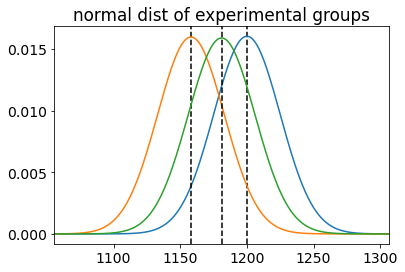

In [44]:
draw_norm(payment_six)
draw_norm(payment_seven)
draw_norm(payment_eight)
plt.title('normal dist of experimental groups');

The normal distribution of the three experimental groups confirms above observation: The graph for the experimental group (green) lies between the graphs of the two control groups (orange and blue). It is clearly visible, that the graphs are overlapping in the area of 95% confidence with sigmas all around 25 (and thus two sigmas around 50, which is larger than the max distance between the means of the two control groups with 1158 and 1200 respectively).

In order to draw the graphs, a boolean was created, according to which a unique user has either reached the payment screen or not. The same logic will now be applied for hypothesis testing for each stage, starting again with the payment one.

In [45]:
exp_funnel = log.pivot_table(index='exp_id',columns='event',values='user_id',aggfunc='nunique')

In [46]:
exp_user = log.groupby('exp_id').agg({'user_id':'nunique'})

In [47]:
exp_users = pd.merge(exp_funnel,exp_user,left_on='exp_id',right_on='exp_id')

In [48]:
exp_users.drop(['Tutorial'],axis=1,inplace=True)
exp_users.rename(columns={'user_id':'users_in_group'},inplace=True)
exp_users=exp_users[['MainScreenAppear','OffersScreenAppear','CartScreenAppear','PaymentScreenSuccessful','users_in_group']]

In [49]:
exp_users

,MainScreenAppear,OffersScreenAppear,CartScreenAppear,PaymentScreenSuccessful,users_in_group
exp_id,,,,,
246,2450,1542,1266,1200,2484
247,2479,1522,1239,1158,2517
248,2494,1531,1230,1181,2537


**H0**: The mean of users reaching this stage from the first test group is the same as the mean of users from the second test group <br>
**H1**: The mean of users reaching this stage from the first test group is NOT the same as the mean of users from the second test group

Significance level alpha for all tests defined as **5%**

In [50]:
true_six_seven = np.array([1200,1158])
all_six_seven = np.array([2484,2517])

zstat, pval = proportions_ztest(count=true_six_seven,nobs=all_six_seven,alternative='two-sided')

print('The p-value for for the ztest between payment events for both control groups is {0:0.4f}'.format(pval))

The p-value for for the ztest between payment events for both control groups is 0.1030


In [51]:
true_six_eight = np.array([1200,1181])
all_six_eight = np.array([2484,2537])

zstat, pval = proportions_ztest(count=true_six_eight,nobs=all_six_eight,alternative='two-sided')

print('The p-value for for the ztest between payment events for groups 246 and 248 is {0:0.4f}'.format(pval))

The p-value for for the ztest between payment events for groups 246 and 248 is 0.2123


In [52]:
true_seven_eight = np.array([1158,1181])
all_seven_eight = np.array([2517,2537])

zstat, pval = proportions_ztest(count=true_seven_eight,nobs=all_seven_eight,alternative='two-sided')

print('The p-value for for the ztest between payment events for groups 247 and 248 is {0:0.4f}'.format(pval))

The p-value for for the ztest between payment events for groups 247 and 248 is 0.6982


In [53]:
def proportions_exp(event_exp1,event_exp2,users_exp1,users_exp2):
    event_sample = np.array([event_exp1,event_exp2])
    exp_sample = np.array([users_exp1,users_exp2])

    zstat, pval = proportions_ztest(count=event_sample,nobs=exp_sample,alternative='two-sided')

    print('The p-value for the proportions ztest is {0:0.4f}'.format(pval))

In [54]:
# all events for control groups 246 and 247
i=0
while i < 4:
    proportions_exp(exp_users.iloc[0,i],exp_users.iloc[1,i],exp_users.iloc[0,4],exp_users.iloc[1,4])
    i = i+1
# all events for control group 246 and experimental group 248   
i=0
while i < 4:
    proportions_exp(exp_users.iloc[0,i],exp_users.iloc[2,i],exp_users.iloc[0,4],exp_users.iloc[2,4])
    i = i+1
# all events for control group 247 and experimental group 248       
i=0
while i < 4:
    proportions_exp(exp_users.iloc[1,i],exp_users.iloc[2,i],exp_users.iloc[1,4],exp_users.iloc[2,4])
    i = i+1

The p-value for the proportions ztest is 0.6756
The p-value for the proportions ztest is 0.2430
The p-value for the proportions ztest is 0.2183
The p-value for the proportions ztest is 0.1030
The p-value for the proportions ztest is 0.3471
The p-value for the proportions ztest is 0.2084
The p-value for the proportions ztest is 0.0784
The p-value for the proportions ztest is 0.2123
The p-value for the proportions ztest is 0.6002
The p-value for the proportions ztest is 0.9294
The p-value for the proportions ztest is 0.5974
The p-value for the proportions ztest is 0.6982


The p-value of all proportion ztests between the three groups and for each stage lies above a significance level of 5%. Thus, we cannot reject the null hypothesis that there is no statistically significant difference between their means.

In [55]:
# ratios of stage reached per total unique users in group
list_six = [2450/2484,1542/2484,1266/2484,1200/2484]
list_seven = [2479/2517,1522/2517,1239/2517,1158/2517]
list_eight = [2494/2537,1531/2537,1230/2537,1181/2537]

In [56]:
chisquare(list_six,f_exp=list_seven)

Power_divergenceResult(statistic=0.0021974239299550713, pvalue=0.99997262190031)

In [57]:
chisquare(list_six,f_exp=list_eight)

Power_divergenceResult(statistic=0.002443421435044979, pvalue=0.9999679005161749)

In [58]:
chisquare(list_seven,f_exp=list_eight)

Power_divergenceResult(statistic=0.0001833070061809734, pvalue=0.9999993399702355)

As could be expected from the previous results the chi square test for expected frequencies of experimental groups over the different stages reveals very high p-values (close to 1). This confirms the alikeness of the two control and the group with altered fonts.

**Conclusion:** The analysed data set covers a week of log files from a startup app. In order to check the effect of altered fonts, an A/A/B test was performed. Around 80.000 events from 2.500 unique users per experimental group were investigated.

The first step of analysis showed high ratios of users that followed through the whole sales funnel. Every second user reached the payment confirmation screen. Between the stages the highest drop-out was noted between main and offer screen, but still three out of five customers reached this stage. Only one out of five, respectively one out of twenty customers left between offer and cart, cart and payment screen.

The normal distribution of the groups for the payment stage then showed that the experimental group lies between the two control groups with all graphs overlapping. In order to draw the graphs a boolean determined for each user whether the end of the payment process was reached or not. The proportions ztest then could not reject the hypothesis that there is no significant difference between the groups, even when each stage of the sales funnel was taken into account by its own.

Thus, there is no reason to not implement the altered fonts in the sales app for visual purposes, even though the A/A/B test has not delivered any reason to do so for commercial purposes.